## Описание проекта: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат "Стальная птица" решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

### Задача
Построить модель, которая будет предсказывать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Перед генерацией новых признаков необходимо изучить сам процесс обработки стали.

## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, которые установлены на крышке ковша.

### Основные этапы:

1. Десульфурация – удаление серы и корректировка химического состава стали с добавлением примесей.
2. Легирование – добавление в сталь сплава:
   - через бункер для сыпучих материалов;
   - либо порошковой проволокой через специальный трайб-аппарат.
3. Анализ и корректировка:
   - Перед первым введением легирующих добавок измеряют температуру стали и проводят химический анализ.
   - Затем температуру повышают, после чего вводят легирующие материалы.
   - После введения продувают сталь инертным газом для перемешивания.
   - Затем повторно измеряют температуру.
   - Этот цикл повторяется, пока не будут достигнуты нужный химический состав и оптимальная температура плавки.

### Финальный этап
После обработки расплавленная сталь направляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (_slab_, «плита»).



# Описание данных:

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

__`steel.data_arc`__ — данные об электродах;

__`steel.data_bulk`__ — данные об объёме сыпучих материалов;

__`steel.data_bulk_time`__ — данные о времени подачи сыпучих материалов;

__`steel.data_gas`__ — данные о продувке сплава газом;

__`steel.data_temp`__ — данные об измерениях температуры;

__`steel.data_wire`__ — данные об объёме проволочных материалов;

__`steel.data_wire_time`__ — данные о времени подачи проволочных материалов.
<br><br>

---

Таблица __`steel.data_arc`__

__`key`__ — номер партии;

__`BeginHeat`__ — время начала нагрева;

__`EndHeat`__ — время окончания нагрева;

__`ActivePower`__ — значение активной мощности;

__`ReactivePower`__ — значение реактивной мощности.
<br><br>

---

Таблица __`steel.data_bulk`__

__`key`__ — номер партии;

__`Bulk1 … Bulk15`__ — объём подаваемого материала.
<br><br>

---

Таблица __`steel.data_bulk_time`__

__`key`__ — номер партии;

__`Bulk1 … Bulk15`__ — время подачи материала.
<br><br>

---

Таблица __`steel.data_gas`__

__`key`__ — номер партии;

__`gas`__ — объём подаваемого газа.
<br><br>

---

Таблица __`steel.data_temp`__ 

__`key`__  — номер партии;

__`MesaureTime`__  — время замера;

__`Temperature`__  — значение температуры.
<br><br>

---

Таблица __`steel.data_wire`__ 

__`key`__  — номер партии;

__`Wire1 … Wire9`__  — объём подаваемых проволочных материалов.
<br><br>

---

Таблица __`steel.data_wire_time`__ 

__`key`__  — номер партии;

__`Wire1 … Wire9`__ — время подачи проволочных материалов.


Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Импорт библиотек

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
from functools import reduce
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from phik.report import plot_correlation_matrix

from phik import phik_matrix


import scipy.stats as stats



# модели
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError


from sklearn.model_selection import cross_val_score


from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 240125

Функция для приведения названий столбцов к более удобному виду

In [2]:
def column_name(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_', regex=True)
    return df

Функция для указания формата и типа даты

In [3]:
def type_time(df, columns, format='%Y-%m-%d %H:%M:%S'):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=format, errors='coerce')
    return df

Функции для построеня графиков

In [4]:
def hist_plot(df, feature):
    plt.figure(figsize=(14,4))
    plt.hist(df[feature], histtype='bar', bins=30)
    plt.title('Гистограмма параметра ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

In [5]:
def boxplot(df, feature):
    plt.figure(figsize=(14,1))
    plt.boxplot(df[feature], vert=False)
    plt.xlabel(feature)
    plt.title('Диаграмма размаха параметра ' + feature)
    plt.show()

# Загрузка данных

In [ ]:
!curl -s -O https://drive.google.com/file/d/1whZw8KNrHYAXvbHFiAPxL1w3DacDv0mR/view?usp=drive_link

In [6]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

Посмотрим на данные из таблицы `data_arc`

In [7]:
query = '''
SELECT *
FROM data_arc
'''

arc = pd.read_sql_query(query, engine)
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [8]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [9]:
arc.duplicated().value_counts()

False    14876
Name: count, dtype: int64

Пропусков и дубликатов нет, приведем тип данных к корректным, а также изменим название столбцов

In [10]:
arc.rename(columns={
    'Начало нагрева дугой': 'begin_heat',
    'Конец нагрева дугой': 'end_heat',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'  
}, inplace=True)
arc = type_time(arc, ['begin_heat', 'end_heat'])

In [11]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим на данные из таблицы `data_bulk`

In [12]:
query = '''
SELECT *
FROM data_bulk
'''

bulk = pd.read_sql_query(query, engine)
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


In [13]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


In [14]:
bulk.duplicated().value_counts()

False    3129
Name: count, dtype: int64

Дубликатов нет. Много пропусков, они означают что материал не был добавлен. Заполним пропуски нулями, приведем тип данных к корректному, а также изменим название столбцов

In [15]:
bulk = column_name(bulk)
bulk = bulk.fillna(0)
bulk[bulk.columns[1:]] = bulk[bulk.columns[1:]].astype(float)

In [16]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Посмотрим на данные из таблицы `data_bulk_time`

In [17]:
query = '''
SELECT *
FROM data_bulk_time
'''

data_bulk_time = pd.read_sql_query(query, engine)
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [18]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [19]:
bulk.duplicated().value_counts()

False    3129
Name: count, dtype: int64

Здесь тоже есть пропущенные значения, их обрабатывать не будем. Приведем тип данных к корректному, а также изменим название столбцов. Дублей нет

In [20]:
data_bulk_time = column_name(data_bulk_time)
data_bulk_time = type_time(data_bulk_time, data_bulk_time.columns[1:])

In [21]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Посмотрим на данные из таблицы `data_gas`

In [22]:
query = '''
SELECT *
FROM data_gas
'''

data_gas = pd.read_sql_query(query, engine)
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [23]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [24]:
data_gas.duplicated().value_counts()

False    3239
Name: count, dtype: int64

Пропущенных значений нет, дубликатов нет, тип данных корректный, изменим название столбцов

In [25]:
data_gas.rename(columns={
    'Газ 1': 'gas'
}, inplace=True)

In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Посмотрим на данные из таблицы `data_temp`

In [27]:
query = '''
SELECT *
FROM data_temp
'''

data_temp = pd.read_sql_query(query, engine)
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [28]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [29]:
data_temp.duplicated().value_counts()

False    18092
Name: count, dtype: int64

Пропуски удалим, приведем тип данных к корректным, а также изменим название столбцов. Дубликатов нет

In [30]:
data_temp.rename(columns={
    'Время замера': 'mesaure_time',
    'Температура' : 'temperature'
}, inplace=True)
data_temp = type_time(data_temp, data_temp.columns[[1]])
data_temp['temperature'] = data_temp['temperature'].astype(float)
data_temp.dropna(inplace=True)

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   mesaure_time  14665 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


Посмотрим на данные из таблицы `data_wire`

In [32]:
query = '''
SELECT *
FROM data_wire
'''

data_wire = pd.read_sql_query(query, engine)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [33]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [34]:
data_wire.duplicated().value_counts()

False    3081
Name: count, dtype: int64

Пропусков нет, дубликатов нет. Приведем тип данных к корректным, а также изменим название столбцов

In [35]:
data_wire = column_name(data_wire)
data_wire = data_wire.fillna(0)
data_wire[data_wire.columns[1:]] = data_wire[data_wire.columns[1:]].astype(float)

In [36]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Посмотрим на данные из таблицы `data_wire_time`

In [37]:
query = '''
SELECT *
FROM data_wire_time
'''

data_wire_time = pd.read_sql_query(query, engine)
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [38]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [39]:
data_wire_time.duplicated().value_counts()

False    3081
Name: count, dtype: int64

Здесь тоже есть пропущенные значения, их обрабатывать не будем. Приведем тип данных к корректному, а также изменим название столбцов. Дубликатов нет

In [40]:
data_wire_time = column_name(data_wire_time)
data_wire_time = type_time(data_wire_time, data_wire_time.columns[1:])

In [41]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


## Вывод:

Загрузили данные. Все таблицы содержат данные, количество таблиц соответствует условию задачи. Переименовали названия столбцов, привели их к нужному типу данных. Избавились  от пропусков в не временных столбцах, дубликатов в данных не обнаружено.

# Исследовательский анализ и предобработка данных

Посмотрим на общее представление  о данных.

In [42]:
arc.describe()

,key,begin_heat,end_heat,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Есть отрицательные значения реактивной мощности. Такое в теории может быть, если обратно в сеть возвращаетя реактивная мощность, но в нашем случае такое не возможно. Посмотрим на распределение признаков и выбросы, чтобы их отсечь

Удалим всю партию, где есть отрицательные значения.

In [43]:
arc[arc['reactive_power'] <0]

,key,begin_heat,end_heat,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [44]:
arc = arc[arc['key'] != 2116]

In [45]:
arc.describe()

,key,begin_heat,end_heat,active_power,reactive_power
count,14872.000000,14872,14872,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.661090,NaN,NaN,0.258916,0.197623


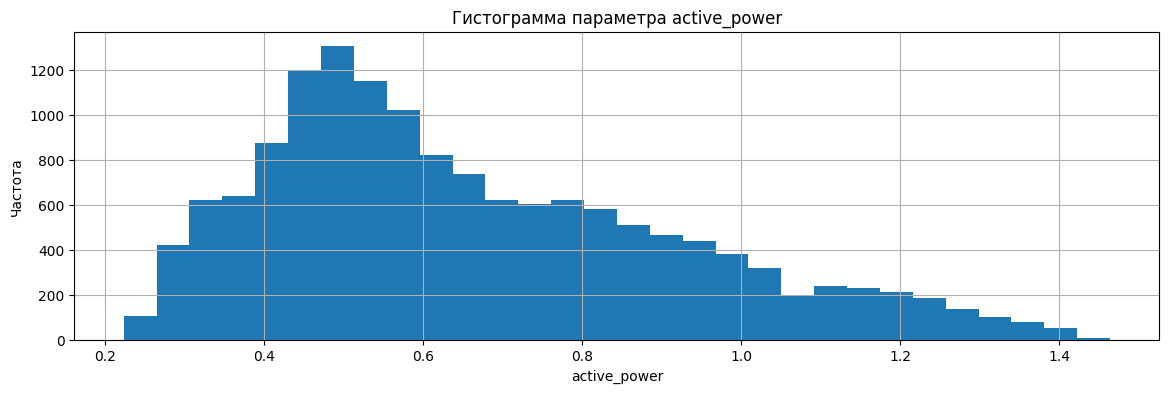

In [46]:
hist_plot(arc, 'active_power')

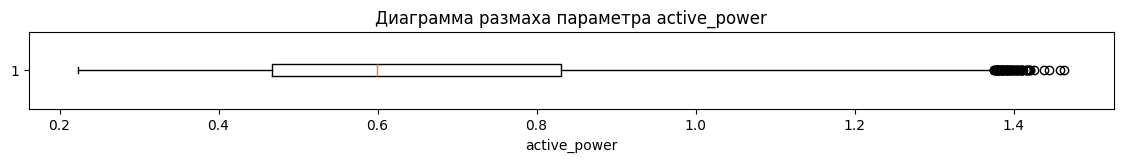

In [47]:
boxplot(arc, 'active_power')

Удалим все партии, в которых значения мощности выходят за доверительный интервал

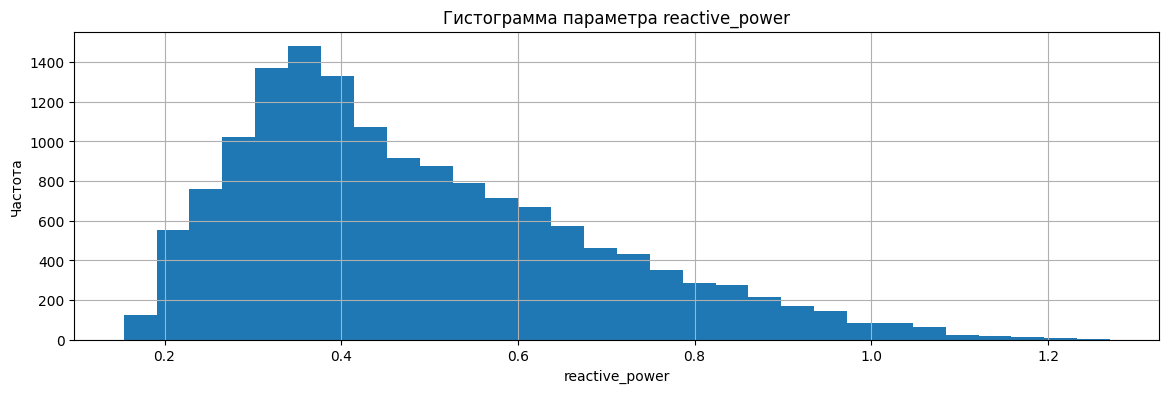

In [48]:
hist_plot(arc, 'reactive_power')

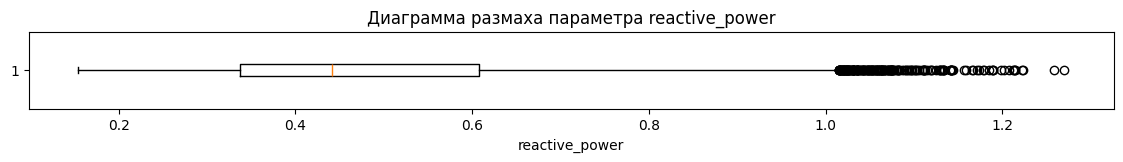

In [49]:
boxplot(arc, 'reactive_power')

Здесь и дальше по проекту будем смотреть на выбросы, но удалять их не будем. Будем трогать только аномальные значения

In [50]:
arc['heating_duration'] = (arc['end_heat'] - arc['begin_heat']).dt.total_seconds()

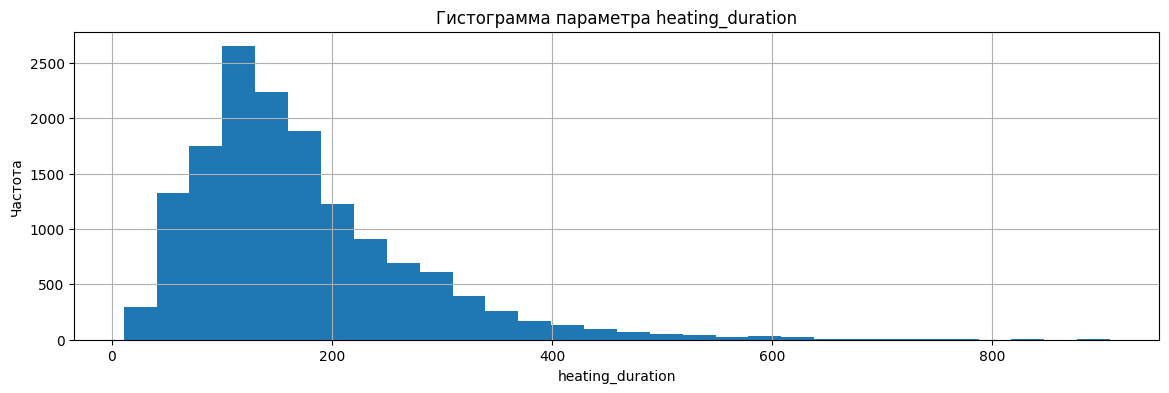

In [51]:
hist_plot(arc, 'heating_duration')

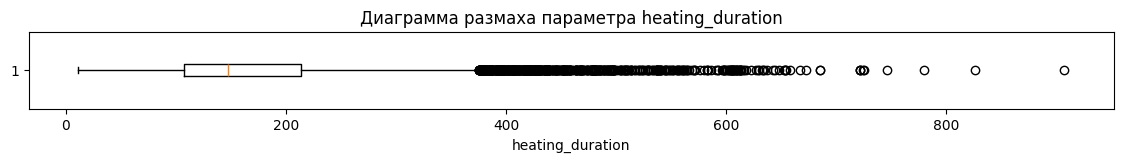

In [52]:
boxploввt(arc, 'heating_duration')

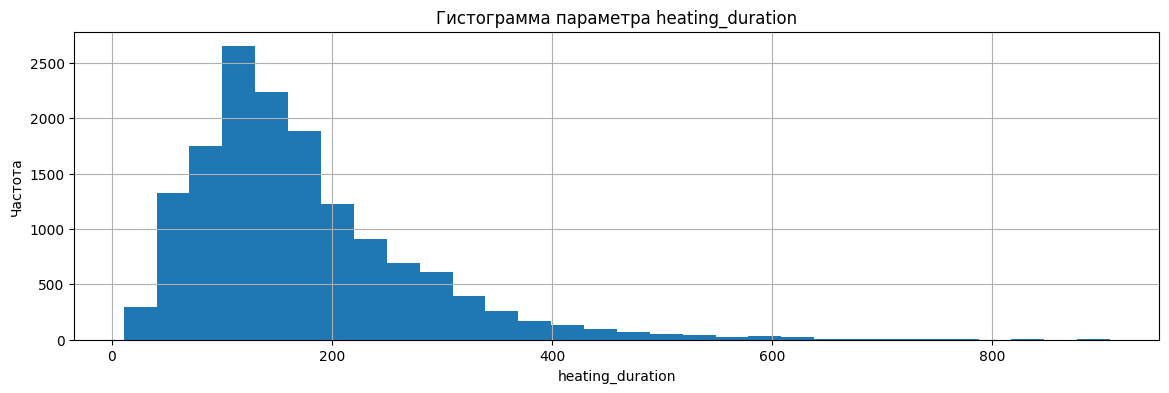

In [53]:
hist_plot(arc, 'heating_duration')

Распределения температур правосторонне скошенное, с длинными хвостами

Выделим новые признаки: плоная мощность (по формуле), работа (время * полную мощность) и соотношение активной и реактивной мощности

In [54]:
arc['full_power'] = np.sqrt(arc['active_power']**2 + arc['reactive_power']**2)
arc['work']  =  arc['full_power'] * arc['heating_duration']
arc['ratio'] = arc['active_power'] / arc['reactive_power']

In [55]:
arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,heating_duration,full_power,work,ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003,1.444382
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978,1.603680
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277,1.348123
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603,1.364539
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252,1.347126


Теперь агрегируем значения для каждой партии и добавим признаки соотношение активной мощности к реактивной и количество запусков нагревания

In [56]:
arc_group = arc.groupby('key', as_index=False).agg(active_power_full = ('active_power', 'sum'),
                                                   reactive_power_full = ('reactive_power', 'sum'),
                                                   heating_duration_full = ('heating_duration', 'sum'),
                                                   full_power = ('full_power', 'sum'),
                                                   power_ratio =  ('ratio', 'mean'),
                                                   work = ('work', 'sum'),
                                                   iteratoin = ('key', 'count'))



In [57]:

arc_group.head()

,key,active_power_full,reactive_power_full,heating_duration_full,full_power,power_ratio,work,iteratoin
0,1,3.036730,2.142821,1098.0,3.718736,1.421570,770.282114,5
1,2,2.139408,1.453357,811.0,2.588349,1.479201,481.760005,4
2,3,4.063641,2.937457,655.0,5.019223,1.396069,722.837668,5
3,4,2.706489,2.056992,741.0,3.400038,1.307446,683.455597,4
4,5,2.252950,1.687991,869.0,2.816980,1.328894,512.169934,4


In [58]:
arc_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3213 non-null   int64  
 1   active_power_full      3213 non-null   float64
 2   reactive_power_full    3213 non-null   float64
 3   heating_duration_full  3213 non-null   float64
 4   full_power             3213 non-null   float64
 5   power_ratio            3213 non-null   float64
 6   work                   3213 non-null   float64
 7   iteratoin              3213 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 200.9 KB


Перейдем к дф bulk. Посмотрим наописание данных

In [59]:
bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Большинство материалов добавляются очень редко, возможно для возможно это из-за изготовления редкихсортов стали или для каких-то обратимых ошибках во врем производства применяется. У признака `bulk_12` есть большое число, сильно отличное от других. Посмотрим на распределение признаков.

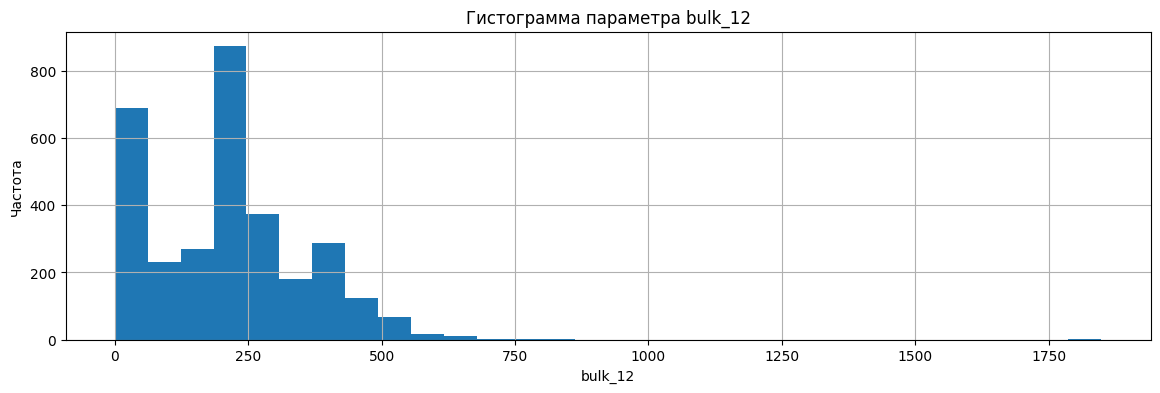

In [60]:
hist_plot(bulk, 'bulk_12')

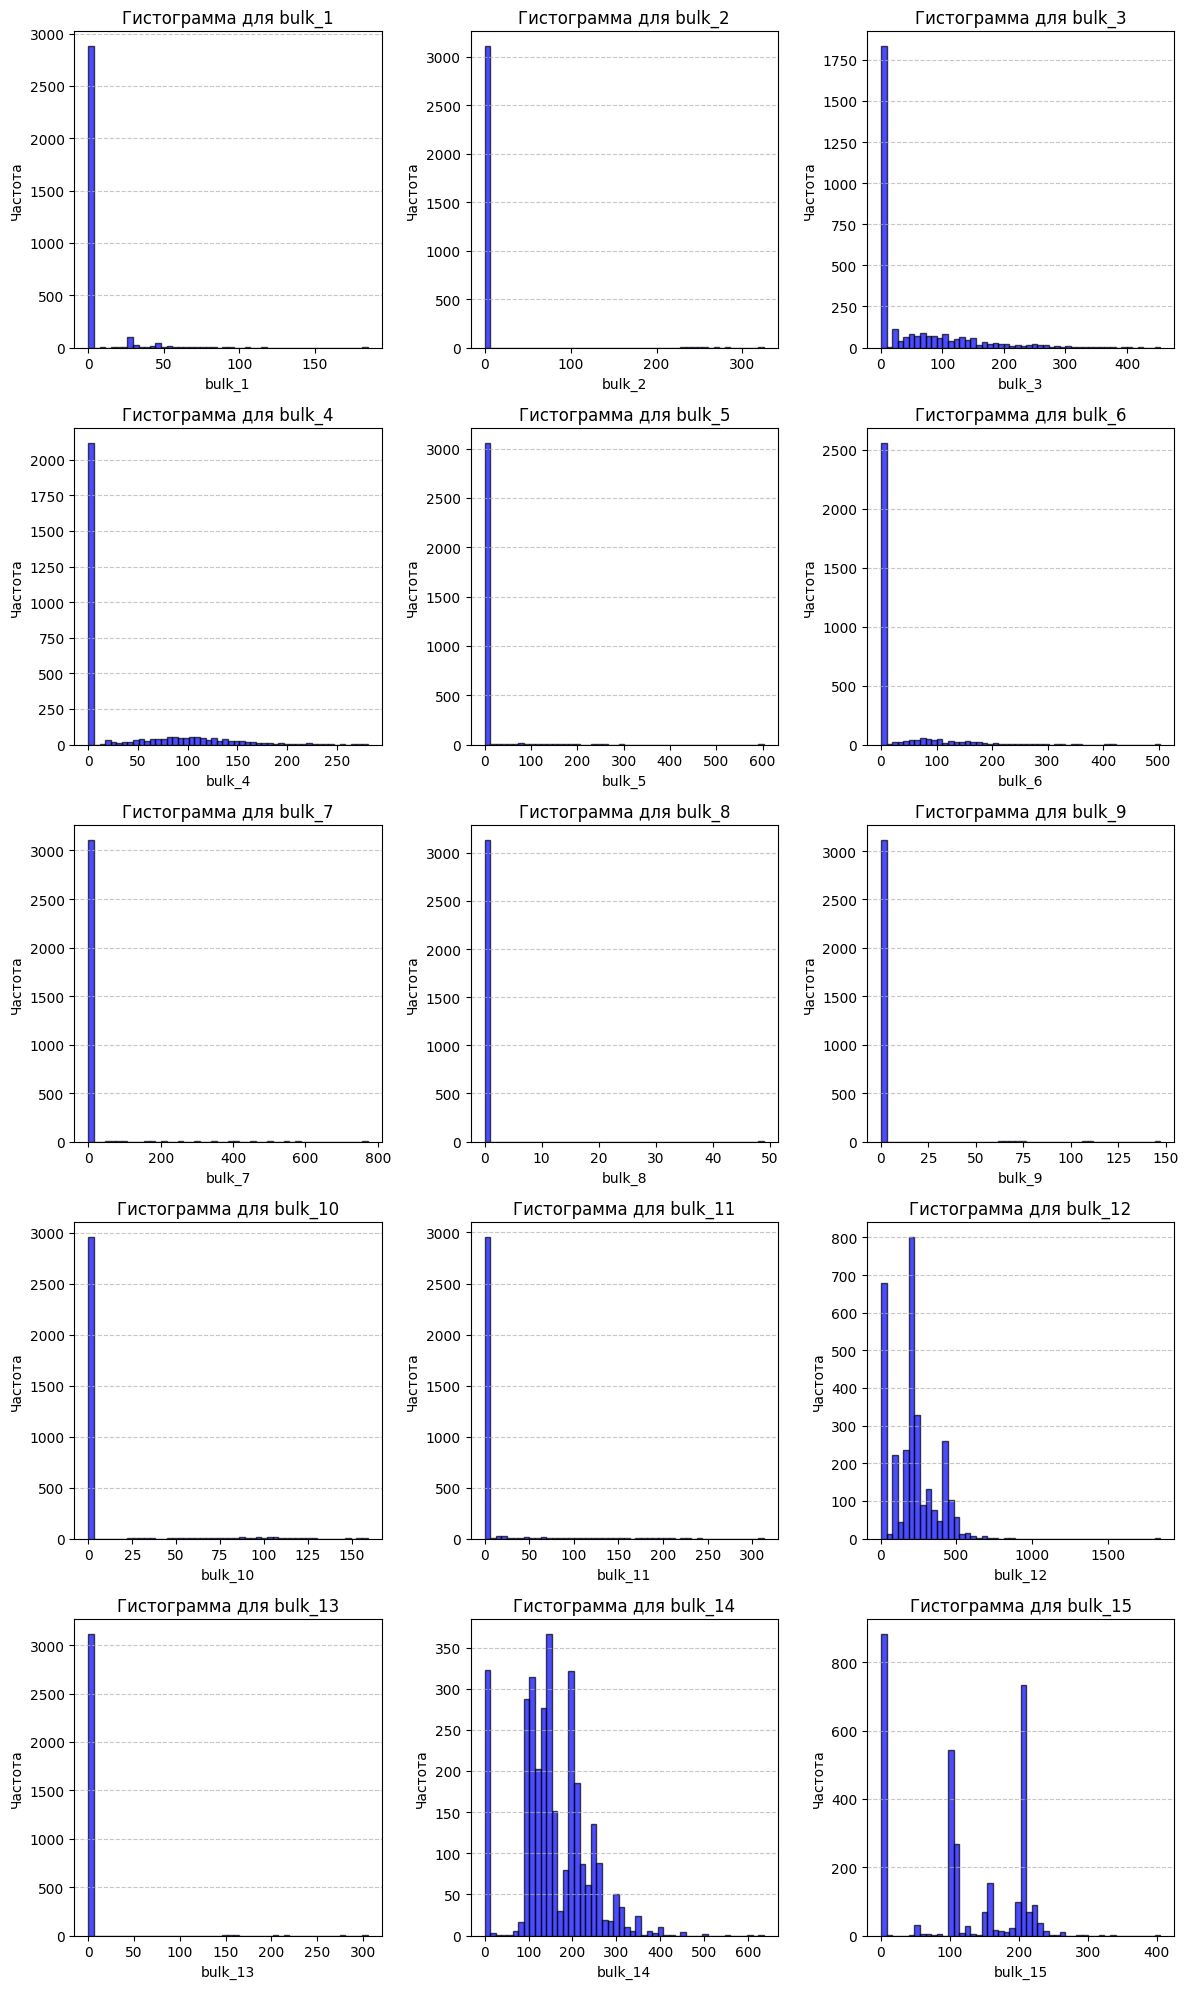

In [61]:
# Настройки расположения графиков
num_columns = 3  # количество графиков в строке
num_rows = -(-len(bulk.columns[1:]) // num_columns)  # округление вверх для вычисления строк

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 4 * num_rows))
axes = axes.flatten()  # превращаем в одномерный массив для удобства

# Построение гистограмм
for i, column in enumerate(bulk.columns[1:]):
    axes[i].hist(bulk[column], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Гистограмма для {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Частота")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Отключение лишних графиков, если их больше, чем колонок
for j in range(len(bulk.columns[1:]), len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # делает графики компактными
plt.show()

Большинство признаков имеют подавлющую часть нулей. Значение 1849 у `bulk_12` похоже на аномалию. Удалим  всю партию. От выбросов тут избавляться не будем, возможно редкие значения используются для редких сортов стали.

In [62]:
bulk[bulk['bulk_12'] == 1849]


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0


In [63]:
bulk = bulk[bulk['key'] != 322]

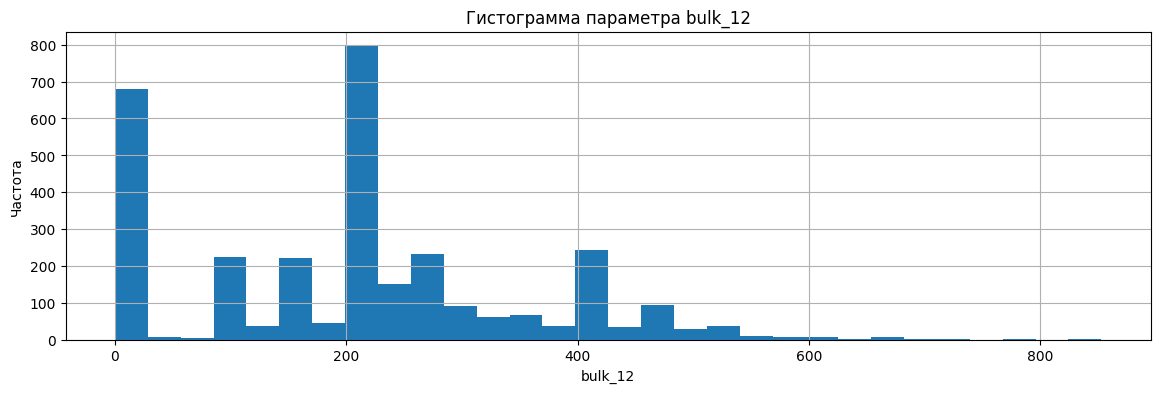

In [64]:
hist_plot(bulk, 'bulk_12')

Перейдем к информации о израсходованном газе. Посмотрим на распределение

In [65]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


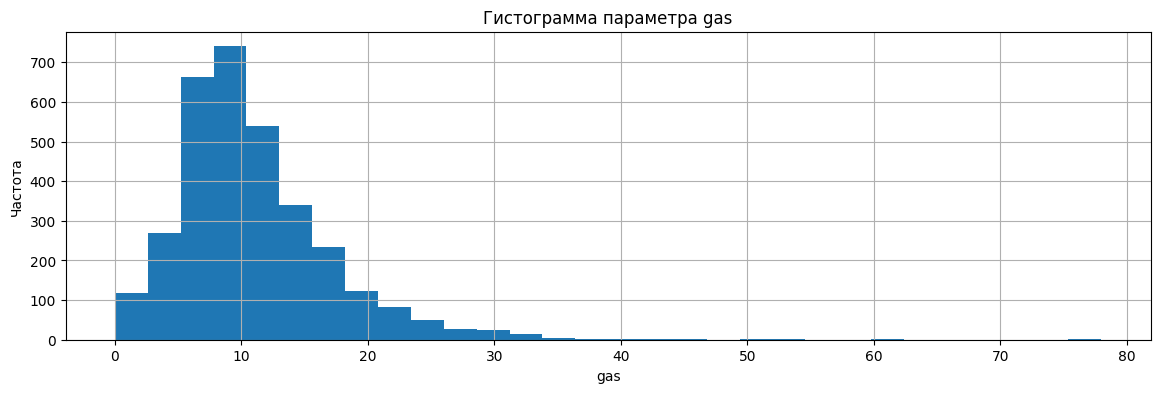

In [66]:
hist_plot(data_gas, 'gas')

Распределение тоже не нормальное, с длинным хвостом

Перейдем к температуре

In [67]:
data_temp.head()

,key,mesaure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [68]:
data_temp.describe()

,key,mesaure_time,temperature
count,14665.000000,14665,14665.000000
mean,1325.484214,2019-06-23 23:59:11.606341632,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,654.000000,2019-05-28 23:56:49,1580.000000
50%,1314.000000,2019-06-21 22:55:49,1590.000000
75%,1963.000000,2019-07-21 22:58:20,1599.000000
max,3241.000000,2019-09-06 16:48:55,1705.000000
std,787.375969,NaN,20.394381


Отсортируем по времени данные для более удобного взятия первой и последней температуры

In [69]:
data_temp = data_temp.sort_values(by='mesaure_time', ascending=True)
data_temp.head()

,key,mesaure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


По условиям заказчика температура ниже 1500 градусов это аномалия, уберем все партии где встречается такая температура

In [70]:
# Группируем по номеру партии и отбираем те, где все значения температуры >= 1500
data_temp = data_temp.groupby('key').filter(lambda x: (x['temperature'] >= 1500).all())

In [77]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14643 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14643 non-null  int64         
 1   mesaure_time  14643 non-null  datetime64[ns]
 2   temperature   14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 457.6 KB


Оставим только партии, где есть данные, больше чем об одном измерении температуры

In [78]:
data_temp = data_temp.groupby('key').filter(lambda x: len(x) > 1)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   mesaure_time  13903 non-null  datetime64[ns]
 2   temperature   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Больше 700  неподходящих партий убрали


Создаем признаки первой и последней температуры сплава

In [82]:
temp = data_temp.groupby('key').agg(
    first_temperature=('temperature', 'first'),
    last_temperature=('temperature', 'last')
).reset_index()


In [83]:
temp.head()

,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


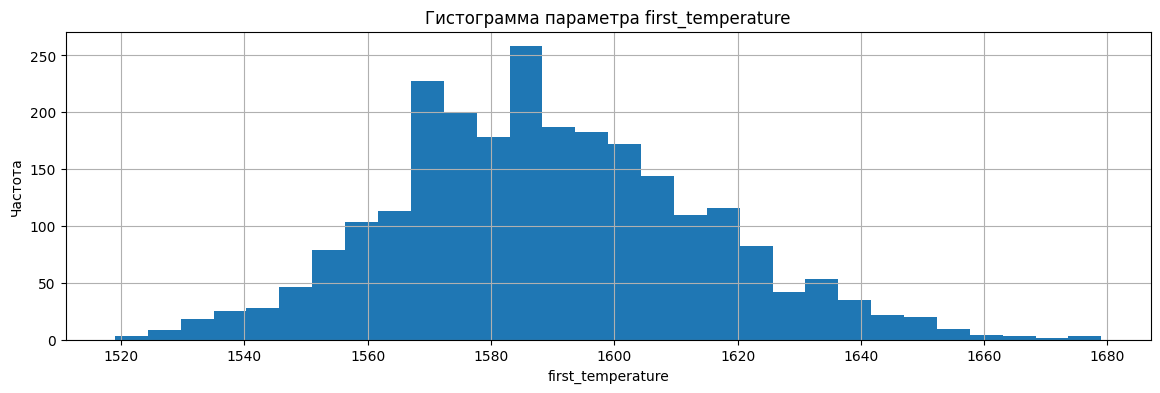

In [84]:
hist_plot(temp, 'first_temperature')

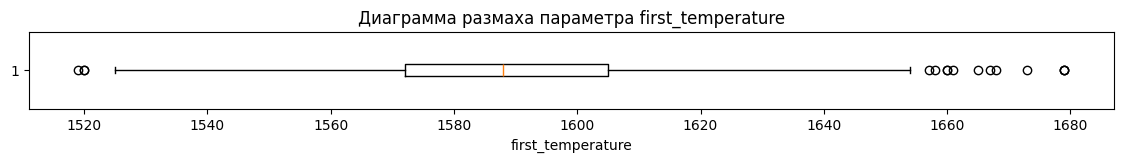

In [85]:
boxplot(temp, 'first_temperature')

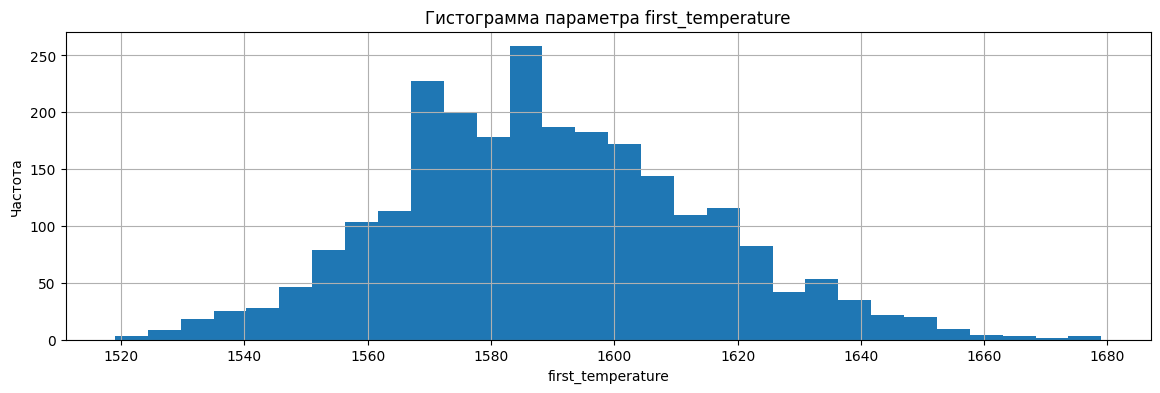

In [86]:
hist_plot(temp, 'first_temperature')

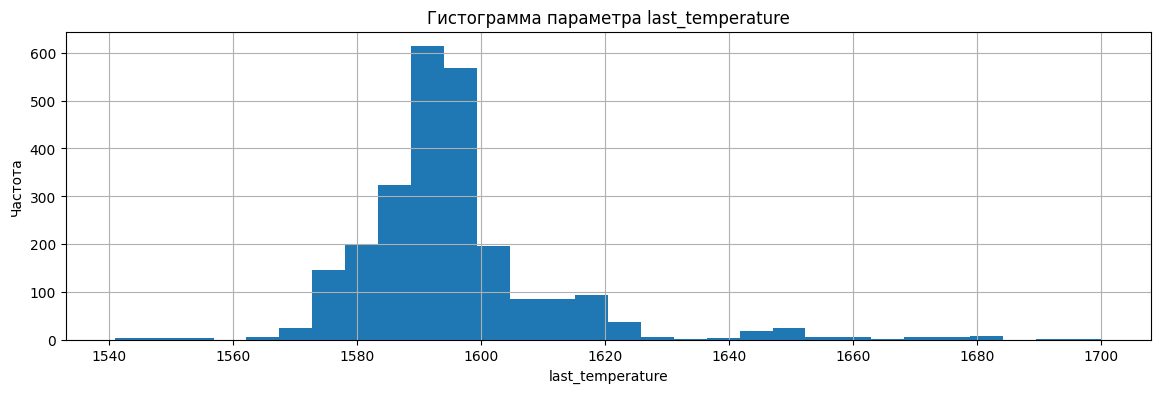

In [87]:
hist_plot(temp, 'last_temperature')

Выбросы есть, но  оставим все как есть

In [88]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2471 non-null   int64  
 1   first_temperature  2471 non-null   float64
 2   last_temperature   2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.0 KB


Посмотрим на данные о проволочных материалах

In [89]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
(data_wire != 0).sum()

key       3081
wire_1    3055
wire_2    1079
wire_3      63
wire_4      14
wire_5       1
wire_6      73
wire_7      11
wire_8      19
wire_9      29
dtype: int64

Много нулевых значений

In [91]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Все значения находятся в одном диапазоне. Только первые два столбца с проволчными материалами несут в себе много данных

## Вывод:

Создали новые признаки первой и последней температуры сплава, полной мощности, работы, агрегировали по ковшу активную и реактивные мощности, количество нагреваний, соотношение мощностей, время нагрева партии

Избавились от аномалий

Распределение признаков близко к нормальному, за исключением данных о добавочных материалах

# Подготовка данных к обучению

Объединим все данные в один дф

In [111]:
dfs = [temp, arc_group, bulk, data_gas, data_wire]

# Объединить все DataFrame в списке по ключу
df_full = reduce(lambda left, right: pd.merge(left, right, on='key', how='inner'), dfs)

In [112]:
(df_full!=0).sum()

key                      2323
first_temperature        2323
last_temperature         2323
active_power_full        2323
reactive_power_full      2323
heating_duration_full    2323
full_power               2323
power_ratio              2323
work                     2323
iteratoin                2323
bulk_1                    198
bulk_2                     13
bulk_3                    957
bulk_4                    810
bulk_5                     53
bulk_6                    437
bulk_7                     12
bulk_8                      1
bulk_9                     13
bulk_10                   143
bulk_11                   130
bulk_12                  1808
bulk_13                    14
bulk_14                  2063
bulk_15                  1696
gas                      2323
wire_1                   2301
wire_2                    808
wire_3                     39
wire_4                     12
wire_5                      0
wire_6                     45
wire_7                      4
wire_8    

Попробуем оставить все признаки в которых мало значений и сравнить при обучении с дф где будут только более информатиные признаки


In [113]:
threshold = 1000 #порог 

# Удаляем столбцы, где количество ненулевых значений меньше порога
df_not_full = df_full.loc[:, (df_full != 0).sum() >= threshold]

In [114]:
(df_not_full!=0).sum()

key                      2323
first_temperature        2323
last_temperature         2323
active_power_full        2323
reactive_power_full      2323
heating_duration_full    2323
full_power               2323
power_ratio              2323
work                     2323
iteratoin                2323
bulk_12                  1808
bulk_14                  2063
bulk_15                  1696
gas                      2323
wire_1                   2301
dtype: int64

Построим матрицу кореляций

interval columns not set, guessing: ['key', 'first_temperature', 'last_temperature', 'active_power_full', 'reactive_power_full', 'heating_duration_full', 'full_power', 'power_ratio', 'work', 'iteratoin', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


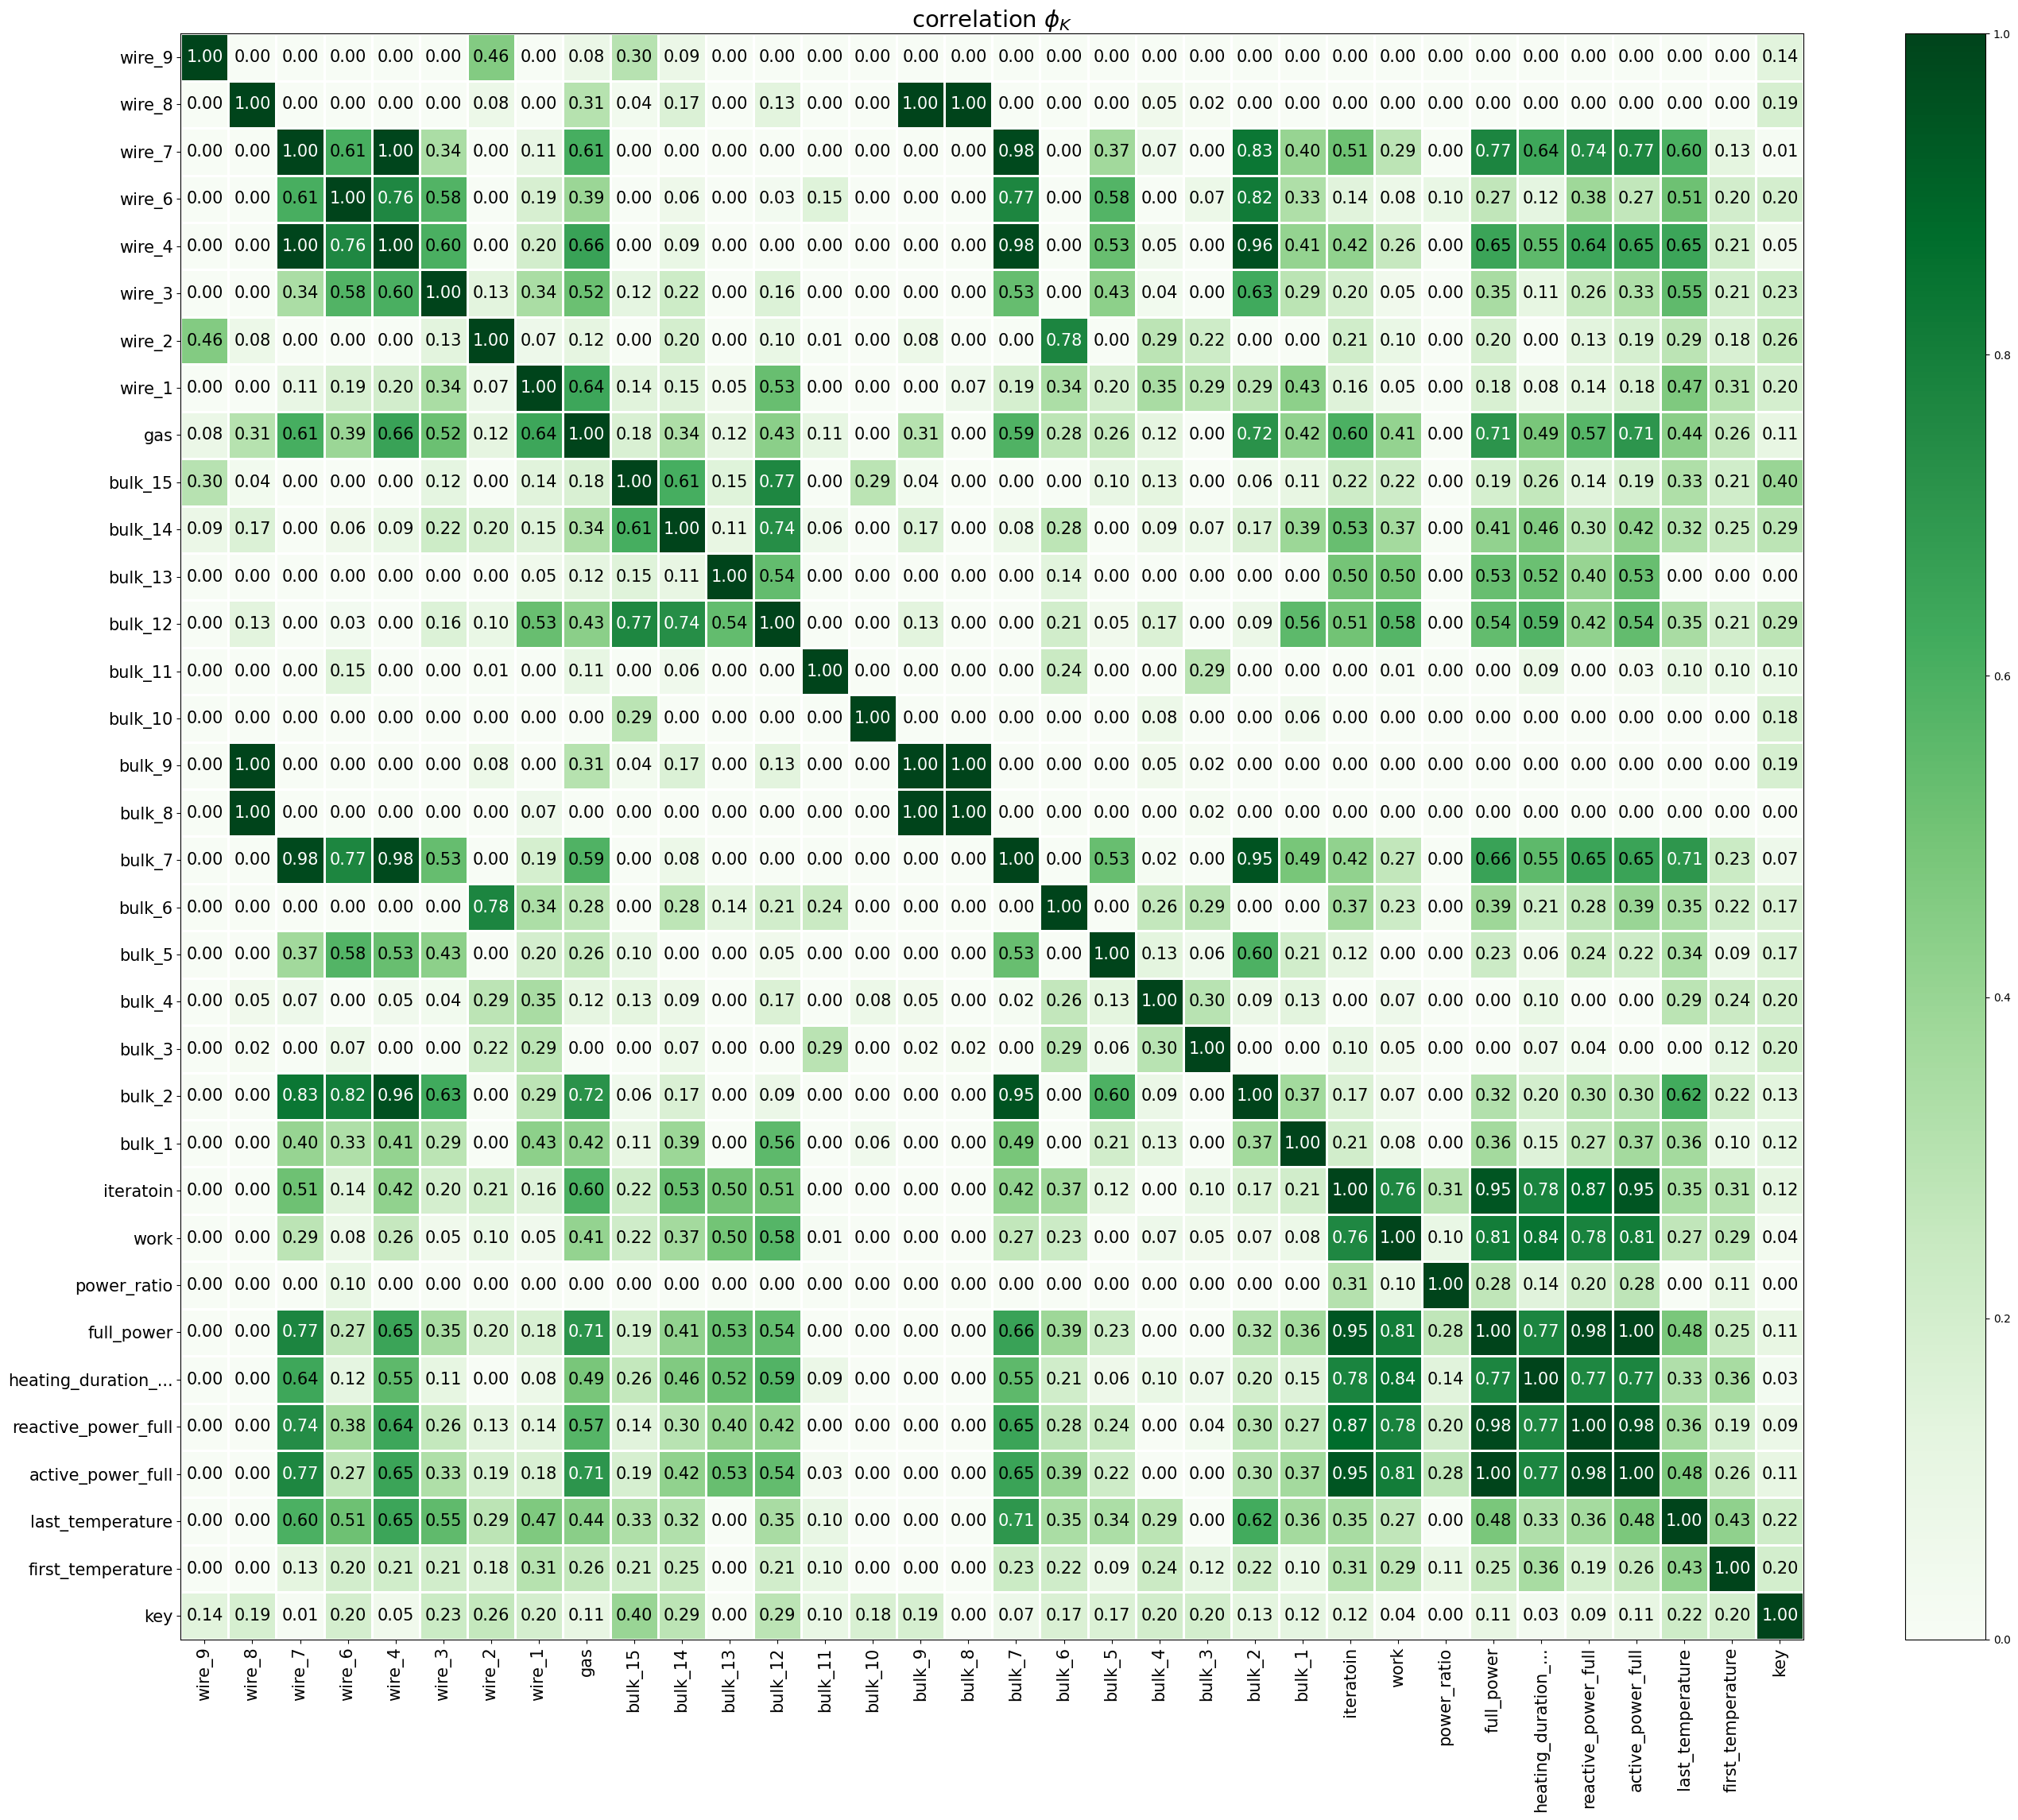

In [115]:
phik_overview = phik_matrix(df_full)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(28, 23)
) 

В df_full оставим все признаки, даже сильно коррелирующие между собой, с таргетом сильной корреляции нет.

Посмотрим на матрицу корреляции для выборочных данных

interval columns not set, guessing: ['key', 'first_temperature', 'last_temperature', 'active_power_full', 'reactive_power_full', 'heating_duration_full', 'full_power', 'power_ratio', 'work', 'iteratoin', 'bulk_12', 'bulk_14', 'bulk_15', 'gas', 'wire_1']


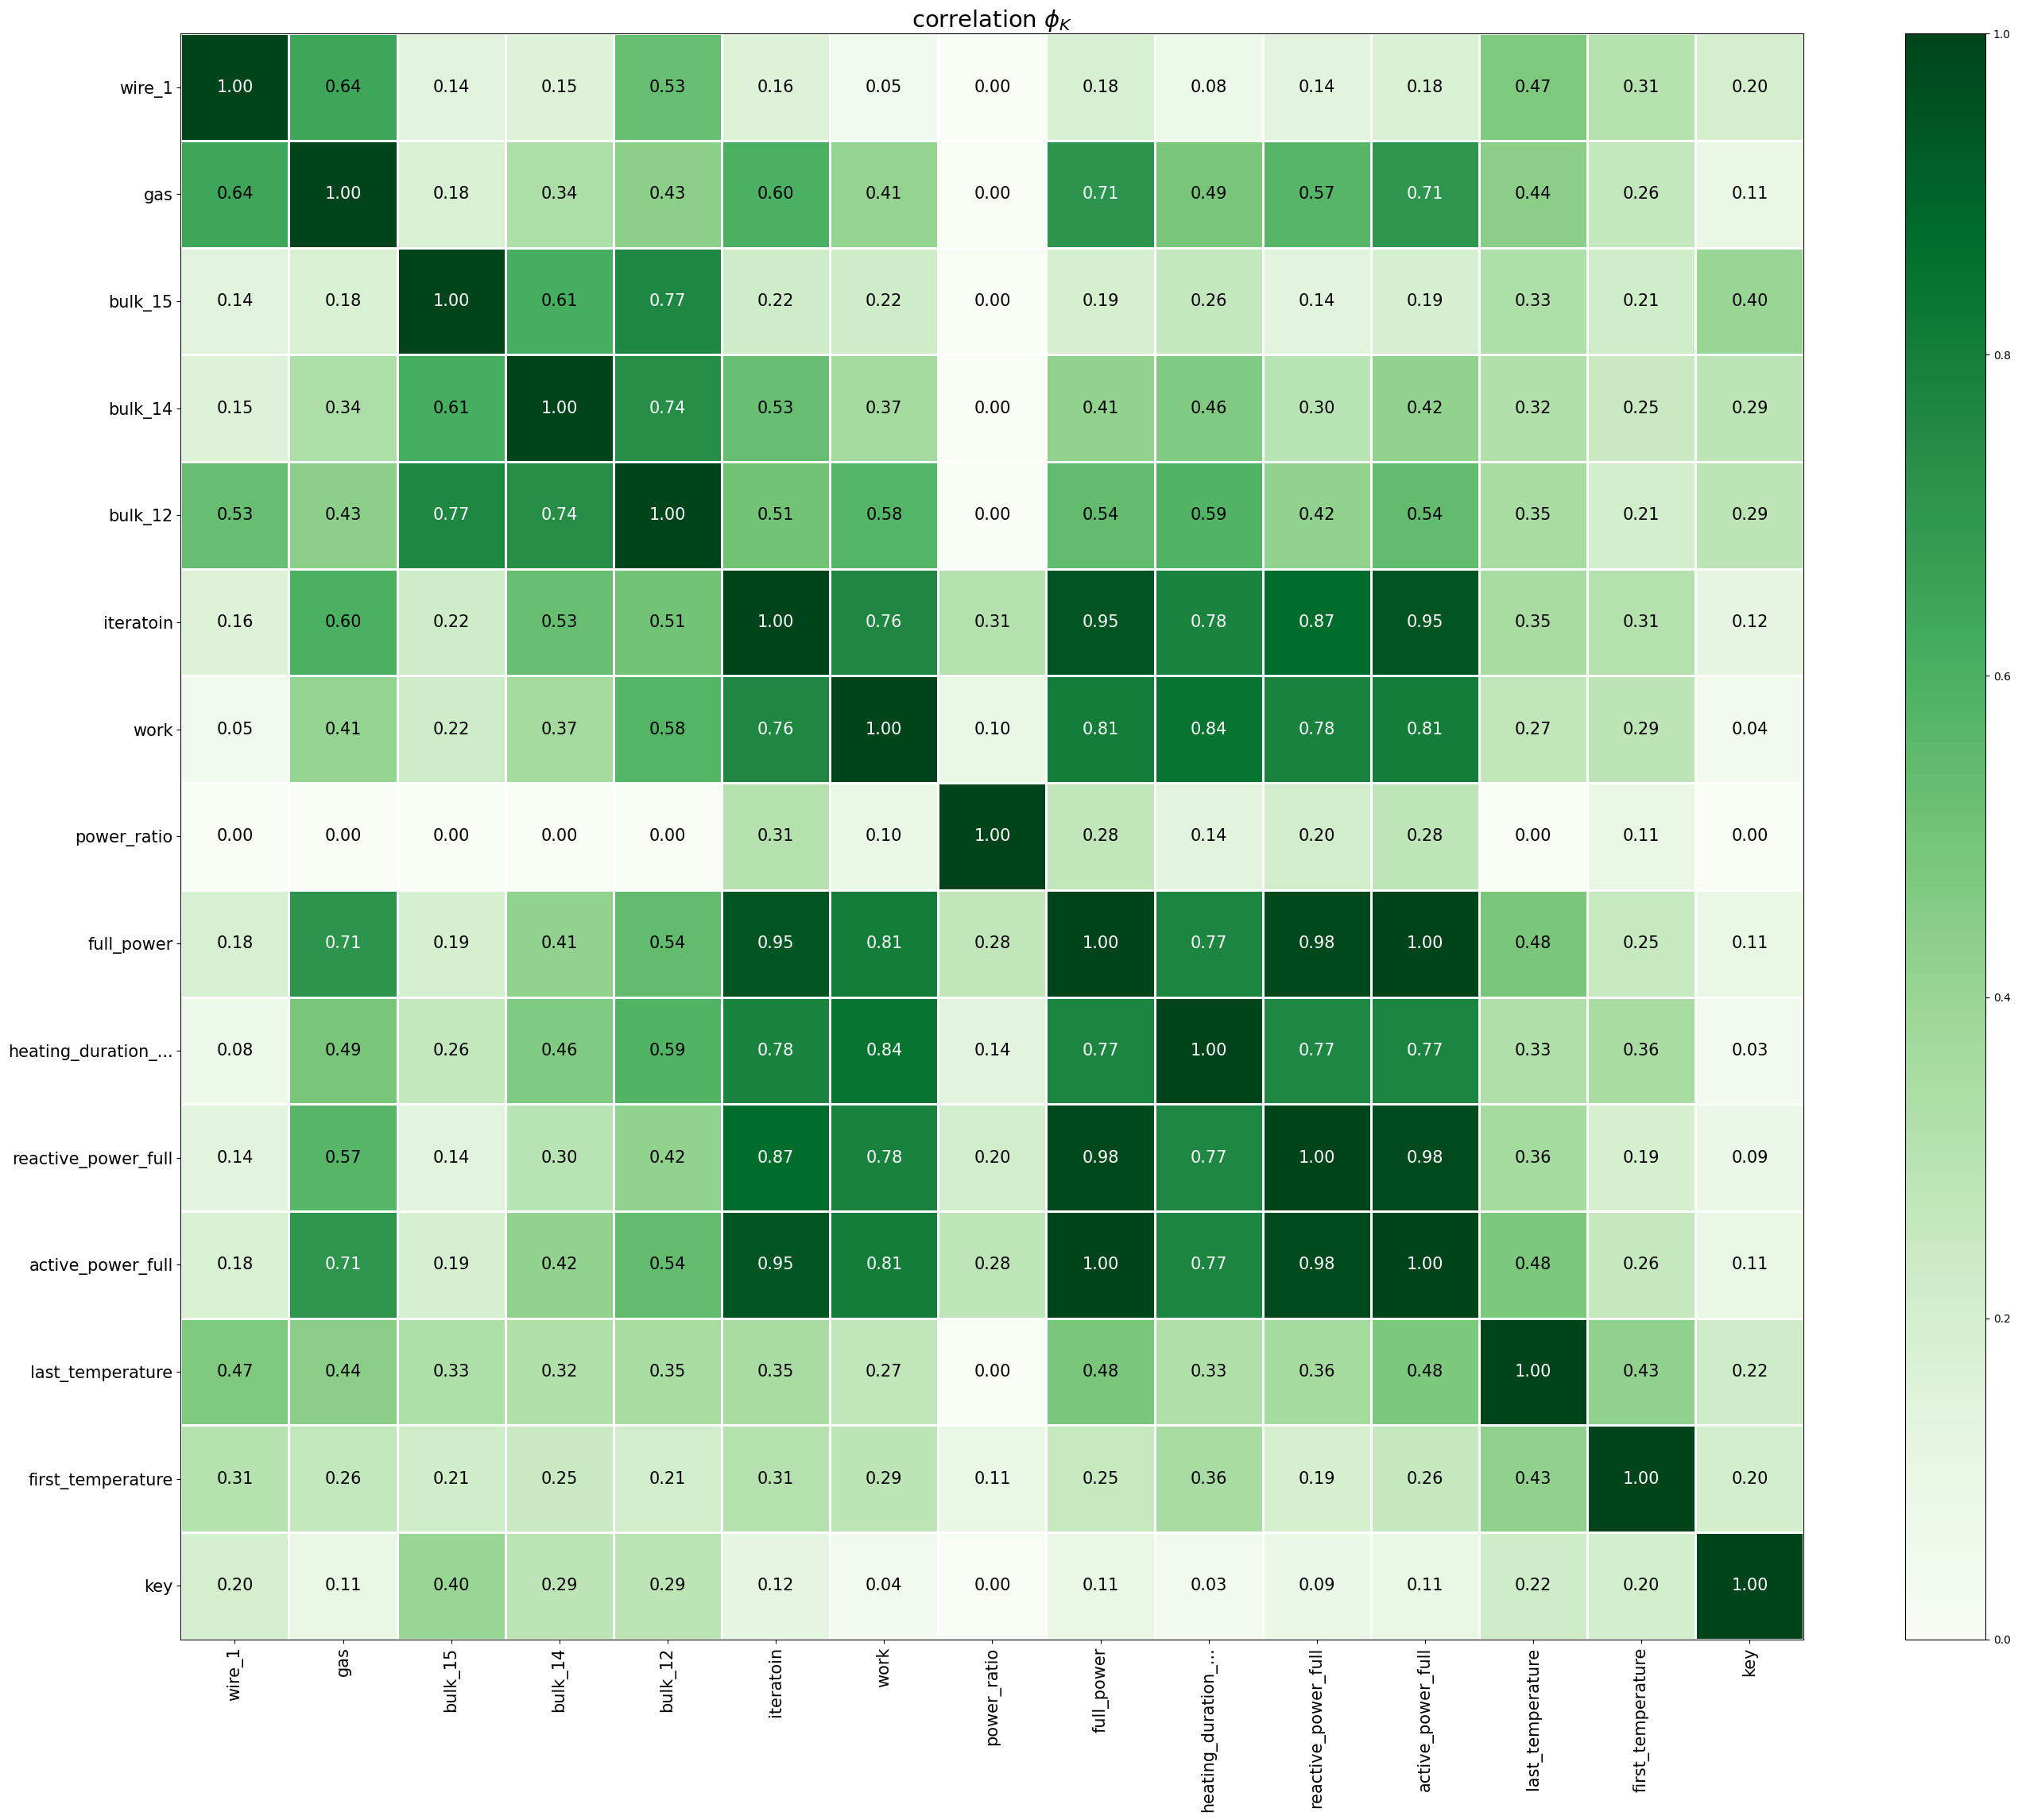

In [116]:
phik_overview = phik_matrix(df_not_full)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(28, 23)
) 

Удалим коррелирующие между собой признаки

In [117]:
df_not_full = df_not_full.drop(['active_power_full', 'reactive_power_full', 'full_power'], axis=1)

interval columns not set, guessing: ['key', 'first_temperature', 'last_temperature', 'heating_duration_full', 'power_ratio', 'work', 'iteratoin', 'bulk_12', 'bulk_14', 'bulk_15', 'gas', 'wire_1']


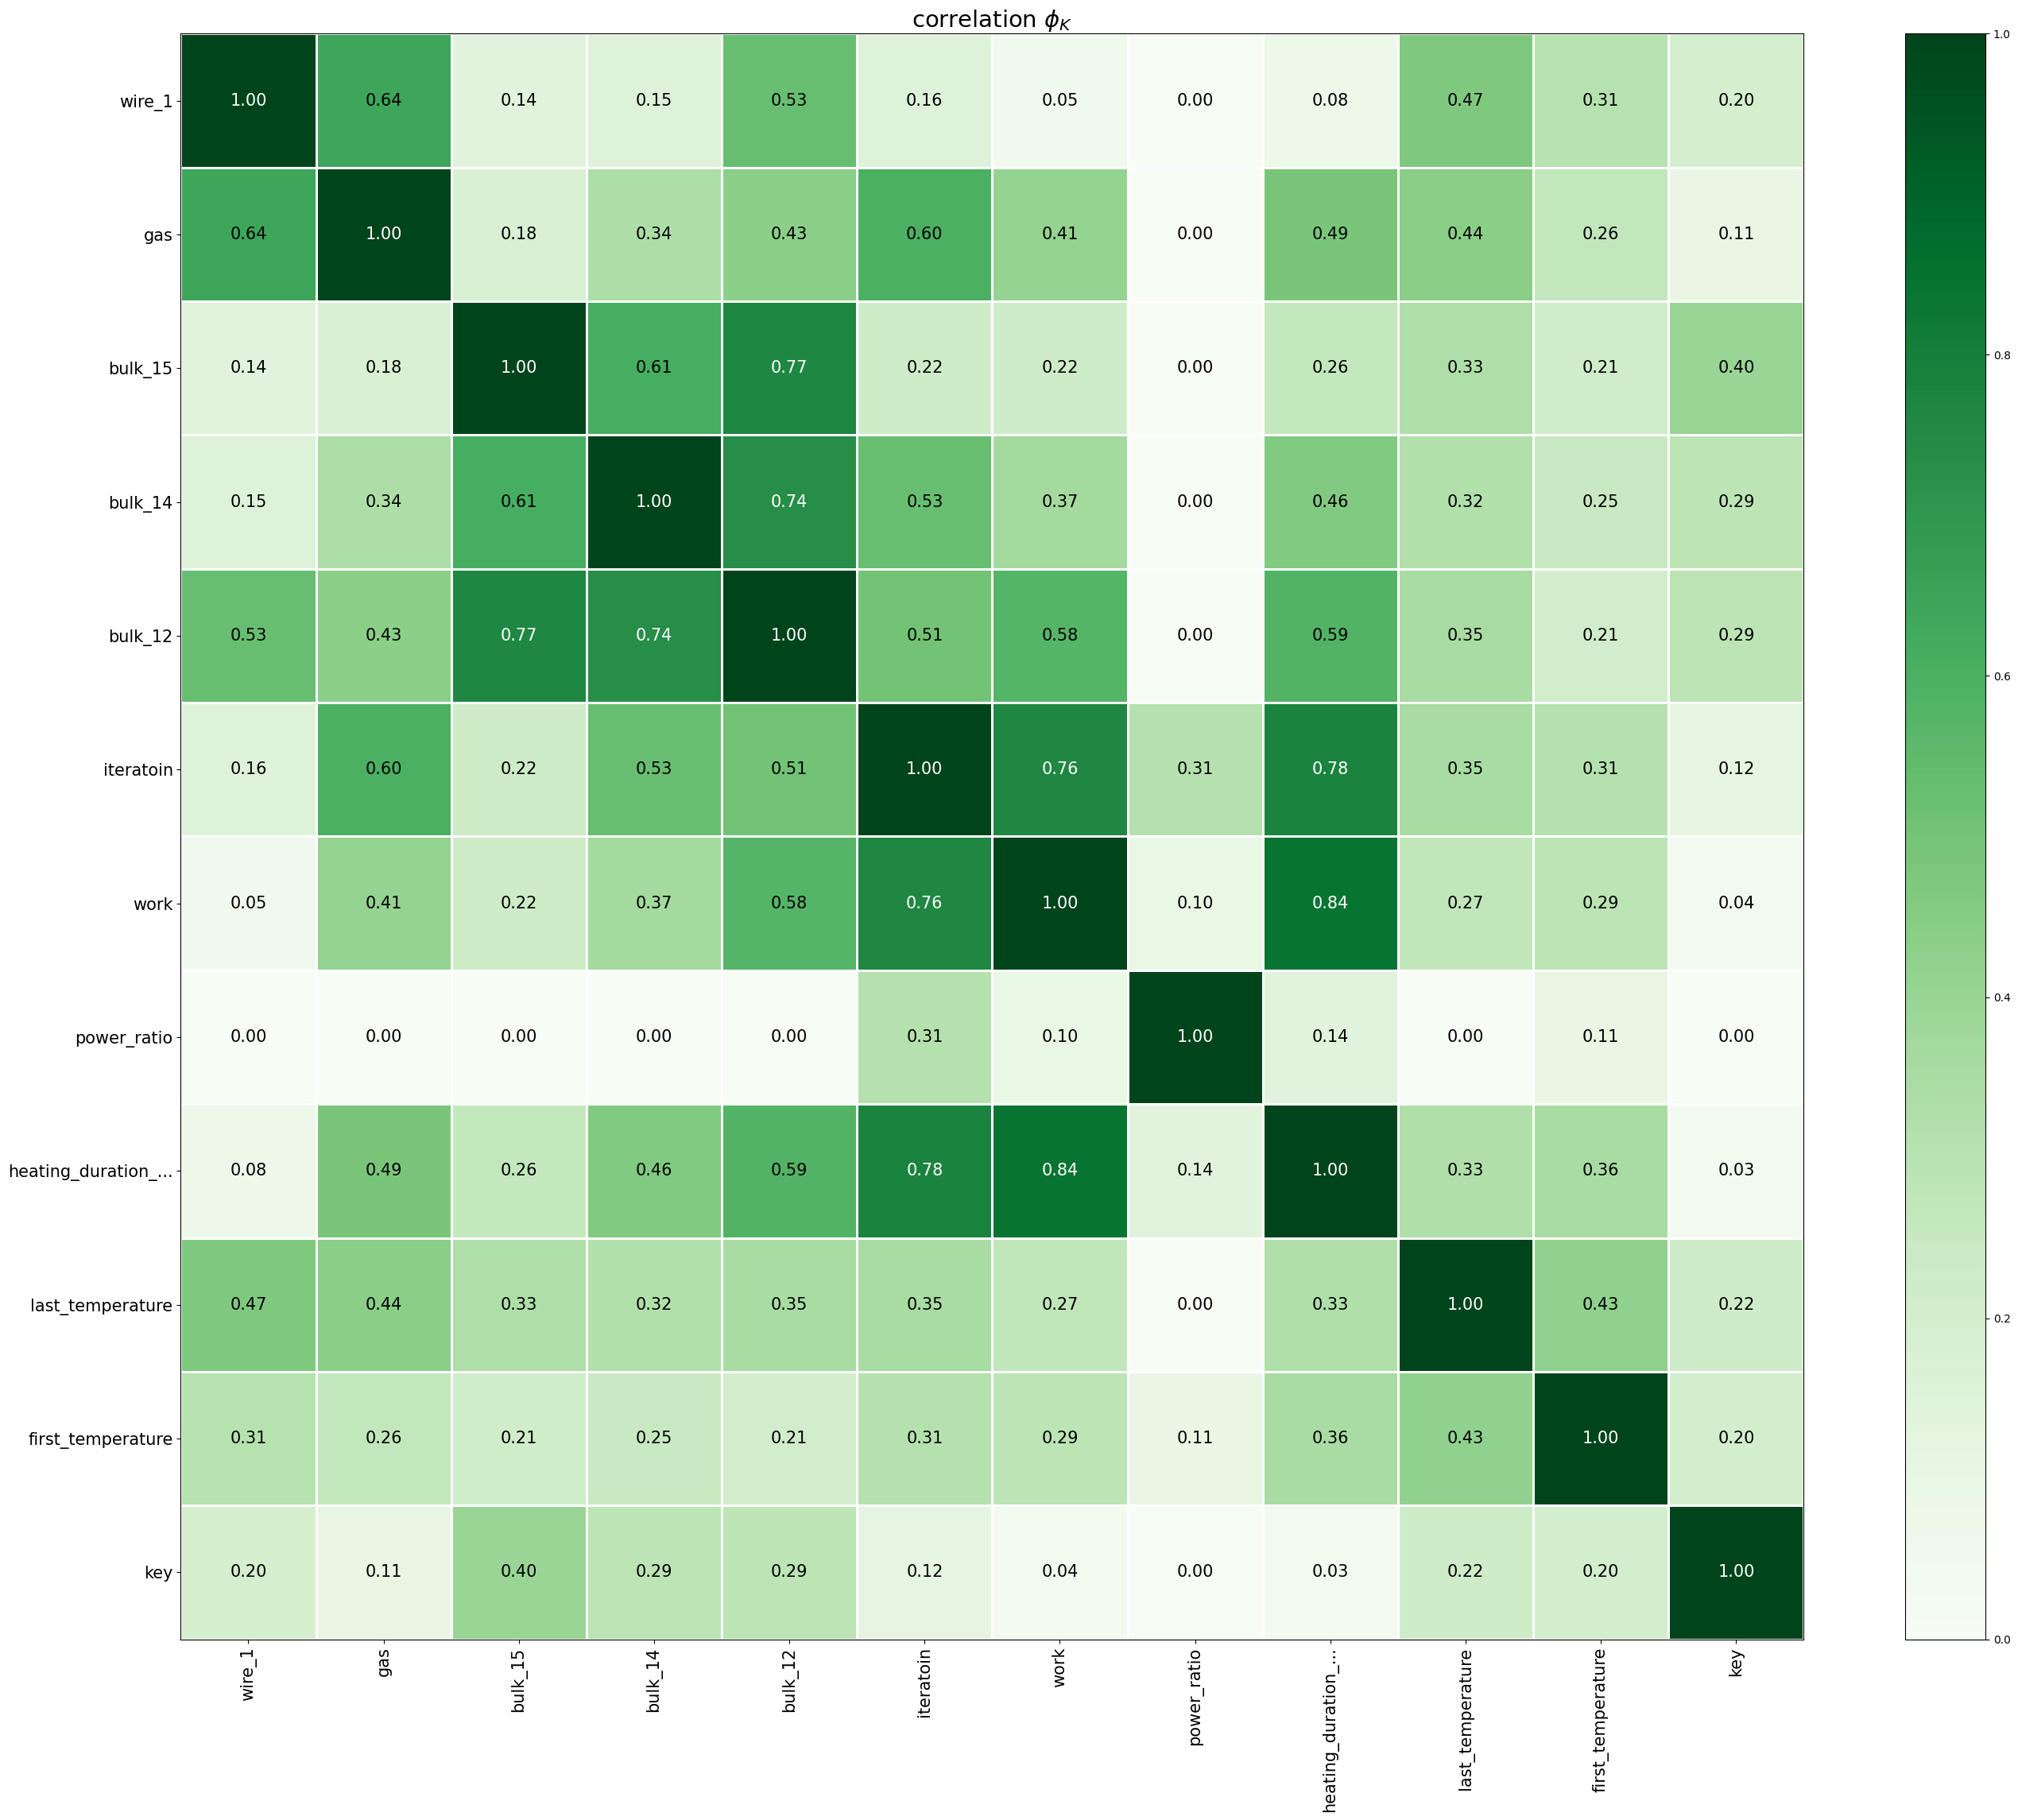

In [118]:
phik_overview = phik_matrix(df_not_full)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(28, 23)
) 

Разделим данные на тетовую и тренировочную выборки 

In [119]:
X_full = df_full.drop(['last_temperature', 'key'], axis=1)
X_not_full = df_not_full.drop(['last_temperature', 'key'], axis=1)
y = df_full['last_temperature']

In [120]:
X_train_full, X_test_full, y_train_f, y_test_f = train_test_split(X_full, y, test_size=0.25, random_state=RANDOM_STATE)
X_train_not_full, X_test_not_full, y_train_nf, y_test_nf = train_test_split(X_not_full, y, test_size=0.25, random_state=RANDOM_STATE)
display(X_test_full.shape)
display(y_test_f.shape)
display(X_train_not_full.shape)
display(y_train_nf.shape)

(581, 33)

(581,)

(1742, 10)

(1742,)

Масштабировать будем через MinMaxScaler так как данные имеют не совсем нормальное распределение и у некоторых признаков есть выбросы.

In [124]:
scaler = MinMaxScaler()
X_train_f = scaler.fit_transform(X_train_full)
X_test_f = scaler.transform(X_test_full)
X_train_nf = scaler.fit_transform(X_train_not_full)
X_test_nf = scaler.transform(X_test_not_full)

Построим две линейные модели с использованием всех данных и и выборочными


In [125]:
# оценка модели через кросс-валидацию
lr_f = LinearRegression()
cv_score_lr_f = cross_val_score(lr_f, 
                X_train_f, 
                y_train_f,
                scoring='neg_mean_absolute_error',                           
                cv=5)


final_cv_score_lr_f = round(np.mean(-cv_score_lr_f), 3)
print('MAE модели линейной регресси со всеми признаками на кросс-валидации', final_cv_score_lr_f)

MAE модели линейной регресси со всеми признаками на кросс-валидации 6.283


In [126]:
# оценка модели через кросс-валидацию
lr_nf = LinearRegression()
cv_score_lr_nf = cross_val_score(lr_nf, 
                X_train_nf, 
                y_train_nf,
                scoring='neg_mean_absolute_error',                           
                cv=5)


final_cv_score_lr_nf = round(np.mean(-cv_score_lr_nf), 3)
print('MAE модели линейной регресси с выборочными признаками на кросс-валидации', final_cv_score_lr_nf)

MAE модели линейной регресси с выборочными признаками на кросс-валидации 6.713


Более информативные признаки показали результат лучше

Случайный лес со всеми параметрами

In [127]:
rf=RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rf = { 
    'n_estimators': [500, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(5,12,2)
}

grid_search_rff = RandomizedSearchCV(estimator=rf, 
                         param_distributions=param_grid_rf, 
                         scoring='neg_mean_absolute_error',  
                         cv= 5,
                         n_jobs = -1)
grid_search_rff.fit(X_train_f, y_train_f)


print("Наилучшие параметры: ",grid_search_rff.best_params_)
print("Науилучшая MAE: ",(-grid_search_rff.best_score_))

Наилучшие параметры:  {'n_estimators': 5000, 'max_features': 'sqrt', 'max_depth': 9}
Науилучшая MAE:  6.610747660875515


Случайный лес  с выборочными признакам

In [128]:
grid_search_rfnf = RandomizedSearchCV(estimator=rf, 
                         param_distributions=param_grid_rf, 
                         scoring='neg_mean_absolute_error',  
                         cv= 5,
                         n_jobs = -1)
grid_search_rfnf.fit(X_train_nf, y_train_nf)


print("Наилучшие параметры: ",grid_search_rfnf.best_params_)
print("Науилучшая MAE: ",(-grid_search_rfnf.best_score_))

Наилучшие параметры:  {'n_estimators': 5000, 'max_features': 'sqrt', 'max_depth': 11}
Науилучшая MAE:  6.602686142807743


Здесь опять выборочные признаки показали метрику лучше

CatBoost со всеми признаками

In [129]:
model_cat = CatBoostRegressor(iterations=1000, learning_rate=0.07, depth=6,verbose=1000)
param_grid_c = {
    'depth': [3,5,7],
    'learning_rate': [ 0.01],
    'iterations': [3500]
}

# Настраиваем GridSearchCV
grid_search_cf = RandomizedSearchCV(estimator=model_cat,
                           param_distributions=param_grid_c,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

# Запускаем поиск по гиперпараметрам
grid_search_cf.fit(X_train_f, y_train_f,   early_stopping_rounds=50)

print("Наилучшие параметры: ",grid_search_cf.best_params_)
print("Науилучшая MAE: ",(-grid_search_cf.best_score_))

0:	learn: 11.2454950	total: 95.6ms	remaining: 5m 34s
1000:	learn: 7.6394214	total: 820ms	remaining: 2.05s
2000:	learn: 6.9019652	total: 1.67s	remaining: 1.25s
3000:	learn: 6.4061908	total: 2.35s	remaining: 391ms
3499:	learn: 6.2079932	total: 2.69s	remaining: 0us
Наилучшие параметры:  {'learning_rate': 0.01, 'iterations': 3500, 'depth': 3}
Науилучшая MAE:  6.04826857800047


CatBoost с выборочными признаками

In [130]:
grid_search_cnf = RandomizedSearchCV(estimator=model_cat,
                           param_distributions=param_grid_c,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

grid_search_cnf.fit(X_train_nf, y_train_nf,   early_stopping_rounds=50)

print("Наилучшие параметры: ",grid_search_cf.best_params_)
print("Науилучшая MAE: ",(-grid_search_cf.best_score_))

0:	learn: 11.2448873	total: 639us	remaining: 2.24s
1000:	learn: 8.1011809	total: 587ms	remaining: 1.46s
2000:	learn: 7.4532364	total: 1.11s	remaining: 832ms
3000:	learn: 6.9700078	total: 1.63s	remaining: 271ms
3499:	learn: 6.7642836	total: 1.9s	remaining: 0us
Наилучшие параметры:  {'learning_rate': 0.01, 'iterations': 3500, 'depth': 3}
Науилучшая MAE:  6.04826857800047


Построим нейронную сеть и обучим на всех данных

In [131]:
model_nn = Sequential()  # Создаем пустую модель

model_nn.add(Dense(8, activation='relu', input_shape=(X_train_f.shape[1],)))  
model_nn.add(BatchNormalization())  # Нормализация пакета для стабилизации обучения
model_nn.add(Dropout(0.3))  # Слой Dropout для предотвращения переобучения

model_nn.add(Dense(2, activation='relu'))
model_nn.add(BatchNormalization())

model_nn.add(Dense(1, activation='linear'))  # Выходной слой

model_nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.05), metrics=[MeanAbsoluteError()])

In [132]:
model_nn.fit(
    X_train_f,
    y_train_f,
    epochs=250,
    batch_size=None,
    verbose=1
)

Epoch 1/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2525231.5000 - mean_absolute_error: 1589.0532
Epoch 2/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2383502.5000 - mean_absolute_error: 1543.6982
Epoch 3/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2034847.1250 - mean_absolute_error: 1425.9738
Epoch 4/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1532535.7500 - mean_absolute_error: 1236.8805
Epoch 5/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 993810.5625 - mean_absolute_error: 995.0793  
Epoch 6/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 535583.1250 - mean_absolute_error: 729.4093
Epoch 7/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232925.6562 - mean_absolute_error: 479.7817
Epoch 8/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78129.5469 - mean_absolute_error: 276.9037 
Epoch 9/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20359.4785 - mean_absolute_error: 140.5227
Epoch 10/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4075

Теперь нейронная сеть на выборочных данных

In [133]:
model_nn = Sequential()  # Создаем пустую модель

model_nn.add(Dense(8, activation='relu', input_shape=(X_train_nf.shape[1],))) 
model_nn.add(BatchNormalization())  # Нормализация пакета для стабилизации обучения
model_nn.add(Dropout(0.3))  # Слой Dropout для предотвращения переобучения

model_nn.add(Dense(2, activation='relu'))
model_nn.add(BatchNormalization())

model_nn.add(Dense(1, activation='linear'))  # Выходной слой

model_nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.05), metrics=[MeanAbsoluteError()])

model_nn.fit(
    X_train_nf,
    y_train_nf,
    epochs=250,
    batch_size=None,
    verbose=1
)

Epoch 1/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2526162.0000 - mean_absolute_error: 1589.3480
Epoch 2/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2386920.0000 - mean_absolute_error: 1544.8077
Epoch 3/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2040354.0000 - mean_absolute_error: 1427.8943
Epoch 4/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1536872.2500 - mean_absolute_error: 1238.5970
Epoch 5/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 995456.1250 - mean_absolute_error: 995.9139  
Epoch 6/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 537231.1875 - mean_absolute_error: 730.4692
Epoch 7/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231798.7344 - mean_absolute_error: 478.6953
Epoch 8/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77757.4531 - mean_absolute_error: 276.2664 
Epoch 9/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19997.7207 - mean_absolute_error: 139.3980
Epoch 10/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4027

Нейронная сеть с полным набором данных лучше

## Вывод:

Построили модели линейной регессю  и нейронную сеть, градиентный бустинг и случайный лес с перебором гиперпараметров. Лучший результат показала модель CatBoostRegression на всех данных

# Проверка модели

Проверим лучшую модель на тестовых данных

In [134]:
y_pred = grid_search_cf.predict(X_test_f)
mae = mean_absolute_error(y_test_f, y_pred)
print(f'Mean Absolute Error: {mae:.3f}')

Mean Absolute Error: 6.111


Метрика устраивает

Посмотрим на метрику R2

In [136]:
r2 = r2_score(y_test_f, y_pred)
print(f'R2 Score: {r2:.3f}')

R2 Score: 0.408


40.8% дисперсии целевой функции смогли объяснить текущими факторами. Это не много, для увеличения  можно поробовать более тщательнее обработать признаки и убрать выбросы в добавочных материалах

Сравним лучшую модель с константной. Для константной будем использовать среднюю температуру

In [137]:
# Преобразуем Series в DataFrame
y_test_df = pd.DataFrame(y_test_f, columns=['last_temperature'])

y_test_df['mean'] = y_test_df['last_temperature'].mean()

# Для оценки качества модели (средняя абсолютная ошибка)
mae = mean_absolute_error(y_test_df['last_temperature'], y_test_df['mean'])
print(f"Средняя абсолютная ошибка константной модели: {mae}")
r2 = r2_score(y_test_df['last_temperature'], y_test_df['mean'])
print(f'R2 константной модели: {r2:.3f}')

Средняя абсолютная ошибка константной модели: 7.756843948204913
R2 константной модели: 0.000


Константная модель значительно проигывает нашей

Изучим важность признаков

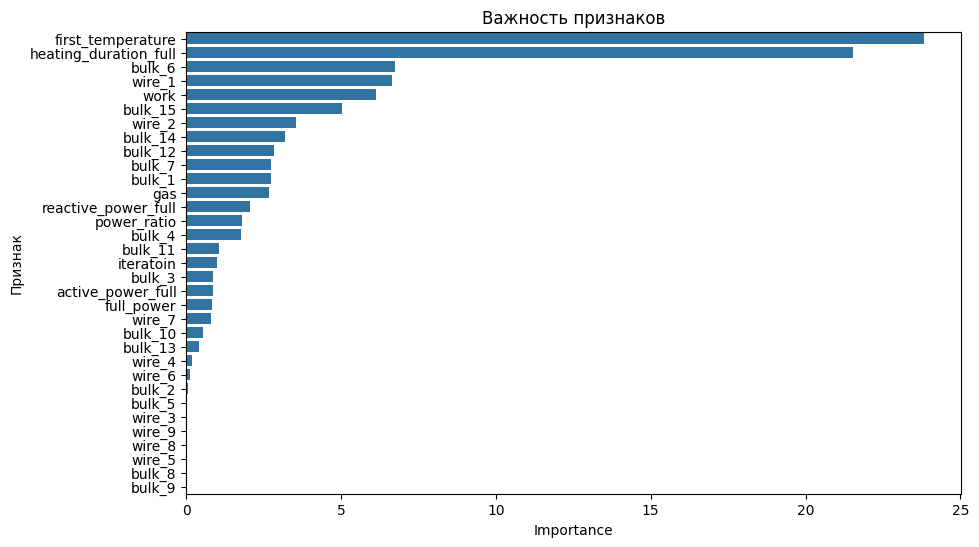

In [138]:
best_model = grid_search_cf.best_estimator_
feature_importances = best_model.get_feature_importance()

# Получение имен признаков из X_test_full
feature_names = X_test_full.columns

# Создание DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков')
plt.ylabel('Признак')
plt.show()

Начальная температура вносит наибольший вклад в предсказание конечной температуры. На втором месте время нагревания партии, 3-4 место занимают добавочные материалы bulk_6 и wire_1, на 5-ом месте работа.

Посмотрим на зависимость температуры сплава от начальной температуры

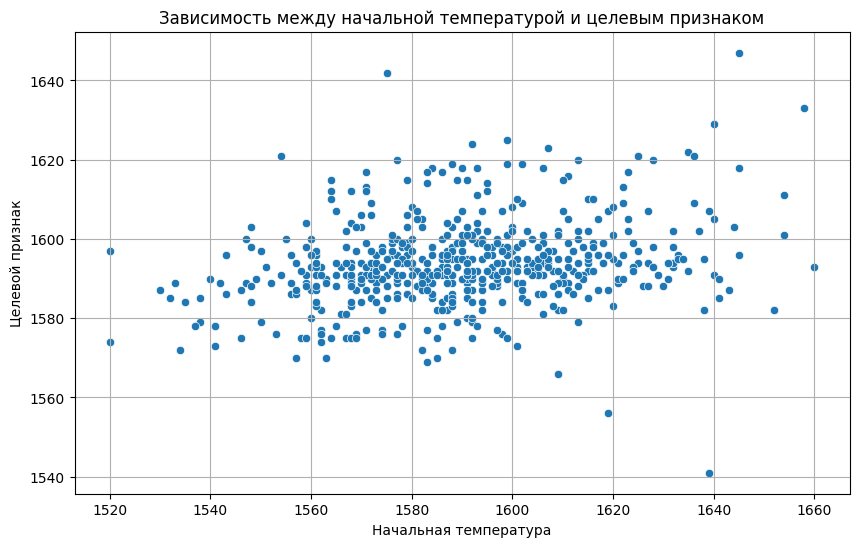

In [140]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_full['first_temperature'], y=y_test_f)

plt.title(f'Зависимость между начальной температурой и целевым признаком')
plt.xlabel('Начальная температура')
plt.ylabel('Целевой признак')
plt.grid()
plt.show()

Видна слабая положительная корреляция с увеличением начальной температуры целевой признак также имеет тенденцию к увеличению, однако разброс значений достаточно большой.

In [141]:
from scipy.stats import pearsonr

Text(0.5, 1.0, 'Гистограмма признака')

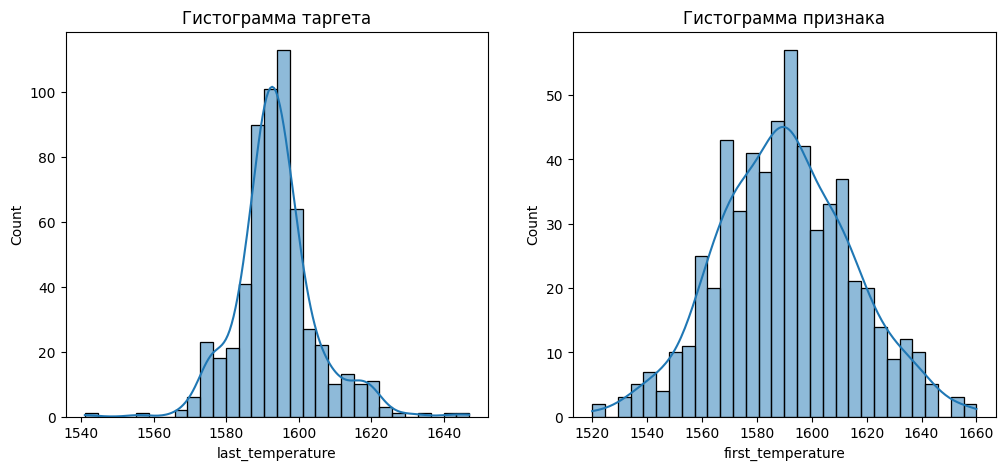

In [144]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_test_f, kde=True, bins=30)
plt.title('Гистограмма таргета')

plt.subplot(1, 2, 2)
sns.histplot(X_test_full['first_temperature'], kde=True, bins=30)
plt.title('Гистограмма признака')

Судя по графикам  похоже на нормальное распределение, с небольшим количеством выбросов. проверим нормальность на тесте Шапиро-Уилка

In [149]:
shapiro_target = stats.shapiro(y_test_f)
shapiro_feature = stats.shapiro((X_test_full['first_temperature']))

print("Тест Шапиро-Уилка для таргета: статистика={}, p-value={}".format(*shapiro_target))
print("Тест Шапиро-Уилка для признака: статистика={}, p-value={}".format(*shapiro_feature))


Тест Шапиро-Уилка для таргета: статистика=0.9510099163053489, p-value=5.843118567224421e-13
Тест Шапиро-Уилка для признака: статистика=0.9976611091407863, p-value=0.5996350597365537


первая температура распределена не нормально, значение p-value слишком маленькое. Воспользуемся коэффицентом корреляции Спирмена


In [151]:

correlation, p_value = stats.spearmanr(y_test_f, X_test_full['first_temperature'])
print(f'Коэффициент корреляции Спирмена: {correlation}, p-значение: {p_value}')

Коэффициент корреляции Спирмена: 0.25302515082842847, p-значение: 6.142903783007434e-10


Корреляция слабая положительная. Между таргетом и признаком есть статистически значимая связь


## Вывод:
- Лучшей оказалась модель CatBoostRegressor обученная на всех признаках с гиперпараметрами 'learning_rate': 0.01, 'iterations': 3500, 'depth': 5
- Метрика качества MAE: 6.779
- R2 Score: 0.423
- Модель работает лучше чем константная Средняя абсолютная ошибка константной модели: 8.79, R2 константной модели: 0.000
- Начальная температура вносит наибольший вклад в предсказание конечной температуры. На втором месте время нагревания партии, 3-4 место занимают добавочные материалы bulk_15 и wire_1, на 5-ом месте количество газа для перемешивания сплава.
- Проанализировав зависимость между последней и начальной температурой видна слабая положительная корреляция с увеличением начальной температуры целевой признак также имеет тенденцию к увеличению, однако разброс значений достаточно большой
- Коэффициент корреляции Спирмена между таргетом и начальной температурой: 0.25 – это слабая положительная корреляция. Означает, что начальная температура и целевой признак связаны, но не очень сильно, p-value: 6.142903783007434e-10 – практически ноль, что говорит о высокой статистической значимости зависимости (связь не случайна).

# Общий вывод:



Проект посвящен оптимизации производственных расходов металлургического комбината «Стальная птица» путем уменьшения потребления электроэнергии на этапе обработки стали. Основная цель — разработать модель для предсказания температуры сплава, что поможет контролировать процесс нагрева и снизить издержки.

Проведенный анализ:

Изучены технологические процессы обработки стали.
Исследованы основные факторы, влияющие на температуру (входные параметры, химический состав, добавки, использование электродов).
Проведена предварительная обработка данных (очистка, заполнение пропусков, нормализация).
Построена модель машинного обучения, предсказывающая температуру на определенном этапе обработки.

Качество модели:

Коэффициент корреляции между фактическими и предсказанными значениями ≈ 0.41 — умеренная связь, но не идеальная.
Проверены различные алгоритмы машинного обучения.
Оптимизированы гиперпараметры для улучшения точности.

<br><br>

Бизнес-рекомендации заказчику:

Использовать разработанную модель для мониторинга температуры в реальном времени.
Настроить автоматическое уведомление о возможных отклонениях от оптимальной температуры.
Снижение затрат

Оптимизировать расход электроэнергии, регулируя мощность нагрева по предсказанным значениям.
Автоматизировать процесс добавления легирующих элементов для точного контроля химического состава.

## Общие выводы по проекту  

### **Проведенный анализ**   
- Очищены данные (заполнены пропуски, проведена нормализация).  
- Построены модели, предсказывающие температуру.  

### **Оценка качества модели**  
- Коэффициент корреляции: 0.49 (средняя связь между прогнозом и фактом).  
- Модель требует доработки для увеличения точности.

## **Способы улучшения модели**  
- Обработать выбросы в добавочных материалах
- Увеличеть время обучения нейронной сети

## **Бизнес-рекомендации**  
1. Внедрить модель для мониторинга температуры в реальном времени.  
2. Использовать разработанную модель для мониторинга температуры в реальном времени.
3. Настроить автоматическое уведомление о возможных отклонениях от оптимальной температуры.
4. Оптимизировать расход электроэнергии, регулируя мощность нагрева по предсказанным значениям.
5. Автоматизировать процесс добавления легирующих элементов для точного контроля химического состава.
